In [58]:
import numpy as np
import pandas as pd
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [59]:
import pyximport
pyximport.install(language_level=3)
import life

In [113]:
def create_model():
    nn = Sequential()
    nn.add(Dense(440, input_shape=(440,), activation='relu'))
    nn.add(Dense(440, activation='relu'))
    nn.add(Dense(440, activation='relu'))
    nn.add(Dense(440, activation='sigmoid'))
    nn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', 'mae'])
    return nn

In [114]:
es = EarlyStopping(monitor='loss', patience=6, min_delta=0.01)

In [115]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 440)               194040    
_________________________________________________________________
dense_18 (Dense)             (None, 440)               194040    
_________________________________________________________________
dense_19 (Dense)             (None, 440)               194040    
_________________________________________________________________
dense_20 (Dense)             (None, 440)               194040    
Total params: 776,160
Trainable params: 776,160
Non-trainable params: 0
_________________________________________________________________


In [116]:
NROW, NCOL = 20, 20

def generate_samples(delta=1, n=32):
    """
    Generate batch of samples
    
    @return: (end_frames, start_frames)
    """
    batch = np.split(np.random.binomial(1, 0.5, (NROW * n, NCOL)).astype('uint8'), n)
    Yy = [life.make_move(state, 5) for state in batch]
    Xx = [life.make_move(state, 1) for state in Yy]
    Y = np.array([y.ravel() for y in Yy])
    X = np.array([x.ravel() for x in Xx])
    return X, Y
    

def data_generator(delta=1, batch_size=32):
    """
    Can be used along with .fit_generator to generate training samples on the fly
    """
    while True:
        batch = np.split(np.random.binomial(1, 0.5, (NROW * batch_size, NCOL)).astype('uint8'), batch_size)
        Yy = [life.make_move(state, 5) for state in batch]
        Xx = [life.make_move(state, delta) for state in Yy]

        Y = np.array([np.concatenate((np.zeros((20, 1), 'uint8'), np.ones((20, 1), 'uint8'), y), axis=1).ravel() for y in Yy])
        X = np.array([np.concatenate((np.zeros((20, 1), 'uint8'), np.ones((20, 1), 'uint8'), x), axis=1).ravel() for x in Xx])
        yield X, Y

In [117]:
model.fit_generator(data_generator(), steps_per_epoch=500, epochs=50, verbose=2, class_weight={0: 0.1, 1:0.9})

Epoch 1/50
 - 5s - loss: 0.4150 - acc: 0.7934 - mean_absolute_error: 0.3021
Epoch 2/50
 - 5s - loss: 0.3828 - acc: 0.7956 - mean_absolute_error: 0.2772
Epoch 3/50
 - 5s - loss: 0.3729 - acc: 0.7978 - mean_absolute_error: 0.2698
Epoch 4/50
 - 5s - loss: 0.3656 - acc: 0.8007 - mean_absolute_error: 0.2642
Epoch 5/50
 - 5s - loss: 0.3627 - acc: 0.8008 - mean_absolute_error: 0.2623
Epoch 6/50
 - 5s - loss: 0.3583 - acc: 0.8031 - mean_absolute_error: 0.2587
Epoch 7/50
 - 5s - loss: 0.3556 - acc: 0.8040 - mean_absolute_error: 0.2567
Epoch 8/50
 - 5s - loss: 0.3535 - acc: 0.8045 - mean_absolute_error: 0.2552
Epoch 9/50
 - 5s - loss: 0.3516 - acc: 0.8057 - mean_absolute_error: 0.2536
Epoch 10/50
 - 5s - loss: 0.3495 - acc: 0.8067 - mean_absolute_error: 0.2520
Epoch 11/50
 - 5s - loss: 0.3487 - acc: 0.8069 - mean_absolute_error: 0.2514
Epoch 12/50
 - 5s - loss: 0.3471 - acc: 0.8077 - mean_absolute_error: 0.2502
Epoch 13/50
 - 5s - loss: 0.3457 - acc: 0.8082 - mean_absolute_error: 0.2491
Epoch 14

In [118]:
X, Y = generate_samples()

In [119]:
xtest = X[0].reshape((20, 20))

In [120]:
ytest = Y[0].reshape((20, 20))

In [121]:
from viz import show_field

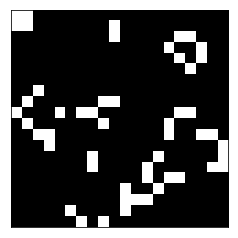

In [122]:
show_field(xtest)

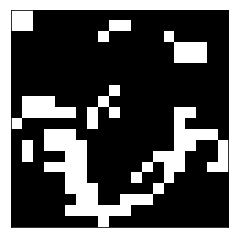

In [123]:
show_field(ytest)

In [124]:
xt = np.concatenate((np.zeros((20, 1), 'uint8'), np.ones((20, 1), 'uint8'), xtest), axis=1).ravel()

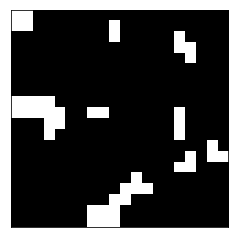

In [125]:
y_pred = model.predict(xt[np.newaxis, :]).round(0).reshape((20, 22))
show_field(y_pred.reshape((20, 22))[:, 2:].ravel())

In [20]:
submit_df = pd.DataFrame(index=test_df.index, columns=['start.' + str(_) for _ in range(1, 401)])

In [26]:
# submit_df[test_df.delta == 1] = models[1].predict(test_df[test_df.delta == 1])
for delta in range(1, 6):
    submit_df[test_df.delta == delta] = models[delta].predict(test_df[test_df.delta == delta].iloc[:, 1:]).round(0)

In [28]:
submit_df.to_csv('nn_submit.csv')